In [1]:
import numpy as np
import pandas as pd
import lambda_dynamics_ToyModel as ld
from importlib import reload
reload(ld)
import DynaMETE_Rfunctions_ToyModel as rf
import matplotlib.pyplot as plt
import brute_force_ToyModel as bf
reload(bf)
%matplotlib inline

In [2]:
# Set up unperturbed parameters

# state variables
s = pd.Series(np.array([50, 1000]), index=['S','N']) #'S' = array.item(0), 'N' is array.item(1)

# parameters. We will derive the precise ones below
# D0 is D1 in the Appendix doc. D0 is hardcoded into R functions.
# Original unperturbed d1: 0.02 --> changed to 0.001
p_d = np.array([0.059,0.02, 0.001, s['N'], s['S']]) #s['N'] gives us array.item(1) (array is the first argument to pd.Series)
p = pd.Series(p_d,index=['b0','d0','d1','Nc', 'Sc']) #to assign the birth rate, unperturbed death rate, and carrying capacity

# To get precise parameters (ss = steady state)
pp = ld.get_ss_params(s,p)

# Initial lambdas
li = rf.lambda_i(s)
# Display parameters and show derivatives are close enough to zero. (-900/2.5*10^5 is still small)
print("Non exact parameters")
display(p)
display(rf.get_dXdt(li,s,p))
print("Exact parameters")
display(pp)
display(rf.get_dXdt(li,s,pp))

Non exact parameters


b0       0.059
d0       0.020
d1       0.001
Nc    1000.000
Sc      50.000
dtype: float64

dS    0.000000e+00
dN   -2.216912e-15
dtype: float64

Exact parameters


b0       0.059
d0       0.020
d1       0.001
Nc    1000.000
Sc      50.000
dtype: float64

dS    0.000000e+00
dN   -2.216912e-15
dtype: float64

In [3]:
import brute_force_ToyModel as bf
reload(bf)
import brute_force_ToyModel as bf
import DynaMETE_Rfunctions_ToyModel as rf
reload(rf)
import DynaMETE_Rfunctions_ToyModel as rf
import lambda_dynamics_ToyModel as ld
from importlib import reload
reload(ld)


# Modified to perturb d1
def BruteForce(l, s, p, time, dt=0.015):
    # print(l)
    # print(s)
    # print(p)
    # print(time)
    # print(dt)
    ret = []
    lam = []
    ds = np.array([])
    counter = 0
    c = 0
    # p['d0'] = l[0] - commented out to perturb d1
    p['d1'] = l[0]
    # prev_d = l[0]
    prev_d1 = l[0]
    counter = 0
    for i in l:
        d_d = prev_d1 - i # previously prev_d - i
        prev_d1 = i # previously prev_d = i
        if(len(ret) > 0):
            print(ret[-1])
        for j in range(1):
            # p['d0'] = i - commented out to perturb d1
            p['d1'] = i  # this makes sure we are perturbing the right thing
            if(counter > 0):
                # l_d0,s_d0,ds_d0 = bf.iterate(time[c],s,p,i-l[counter-1], dt=dt, verbose = False, l0 = last_lambda, ds0 = last_d0)
                l_d1, s_d1, ds_d1 = bf.iterate(time[c], s, p, i - l[counter - 1], dt = dt, verbose = False, l0 = last_lambda, ds0 = last_d1)
            else:
                # l_d0,s_d0,ds_d0 = bf.iterate(time[c],s,p,0, dt=dt, verbose = False)
                l_d1, s_d1, ds_d1 = bf.iterate(time[c], s, p, 0, dt = dt, verbose = False)
            
            
            # s = s_d0.iloc[-1]
            s = s_d1.iloc[-1]
            # ret += list(s_d0['N'][1:])
            ret += list(s_d1['N'][1:])
      
            # lam += list(l_d0[1:])
            # last_lambda = l_d0[-1]

            lam += list(l_d1[1:])
            last_lambda = l_d1[-1]


            # last_d0 = ds_d0.iloc[-1]
            last_d1 = ds_d1.iloc[-1]
            # ds = np.append(ds, np.array(ds_d0['dN'][1:]))
            ds = np.append(ds, np.array(ds_d1['dN'][1:]))
            counter += 1
        c += 1
    
    return ret,lam, ds
        

In [4]:
# NOT YET CHANGED TO PERTURB D1

def Lambda(l, s, p, time, dt=0.015):
    # dt = time step for ld.iterate
    # l (in plot below): initial death rates (transition rate parameters)
    ret = [] # values of N
    lam = [] # lambdas
    ds = np.array([]) # derivatives of transition rate parameters
    counter = 0 
    c = 0 # count number of iterations?
    # what is the difference between counter vs c?
    p['d0'] = l[0] # p = parameters
    prev_d = l[0] # keep track of previous values of d0
    counter = 0 
    for i in l:
        d_d = prev_d - i
        prev_d = i
        if(len(ret) > 0):
            print(ret[-1])
        # do only once
        for j in range(1):
            p['d0'] = i # update d0 (death rate constant)
            if(counter > 0):
                # do one iteration, d_d- specific value of transition rate parameters (e.g. death rate)
                l_d0,s_d0,ds_d0 = ld.iterate(time[c],s,p, dt, d_d = i-l[c-1], verbose = False, l = last_lambda, ds = last_d0)
            else:
                l_d0,s_d0,ds_d0 = ld.iterate(time[c],s,p, dt, verbose = False)
            s = s_d0.iloc[-1]
            ret += list(s_d0['N'][1:])
      
            lam += list(l_d0[1:])
            last_lambda = l_d0[-1]

            last_d0 = ds_d0.iloc[-1]
            ds = np.append(ds, np.array(ds_d0['dN'][1:]))
            counter += 1
        c += 1
    
    
    
    return ret,lam, ds

Perturb d1

1000.0


Text(0.5, 1.0, 'Values of N for Perturbation in d1')

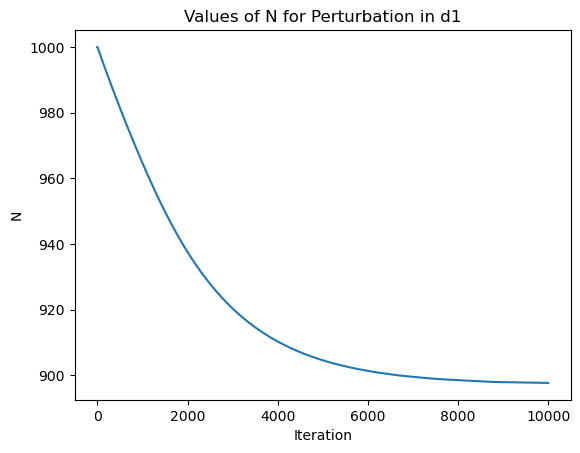

In [5]:
times = [1, 10000]
# originally 0.022, 0.02 for d0
d1a_, d1b_, d1c_ = BruteForce([0.001, 0.0011], s, pp, time = times, dt = 0.01)
# return N, lambdas, derivatives
plt.plot(d1a_)
plt.xlabel("Iteration")
plt.ylabel("N")
plt.title("Values of N for Perturbation in d1")

In [6]:
d1a_[-1]

897.7203788632214

In [7]:
d1b_[-1]

array([0.05936141, 0.04956806])

In [8]:
d1c_[-1]

-0.020814518626655655

In [9]:
lambda_2s = np.array([d1b_[i][1] for i in range(len(d1b_))])
lambda_2s

array([2.47872223e-15, 1.36156188e-13, 5.34524219e-05, ...,
       4.95680128e-02, 4.95680380e-02, 4.95680633e-02])

Text(0.5, 1.0, 'Values of Lambda 2 for Perturbation in d1')

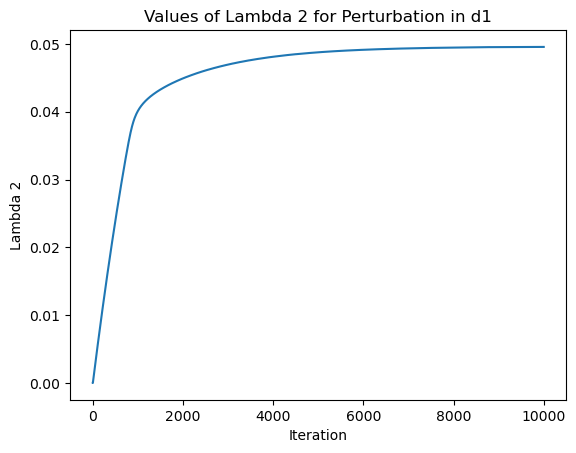

In [10]:
plt.plot(lambda_2s)
plt.xlabel("Iteration")
plt.ylabel("Lambda 2")
plt.title("Values of Lambda 2 for Perturbation in d1")

Text(0.5, 1.0, 'Values of N and Lambda 2 for Perturbation in d1')

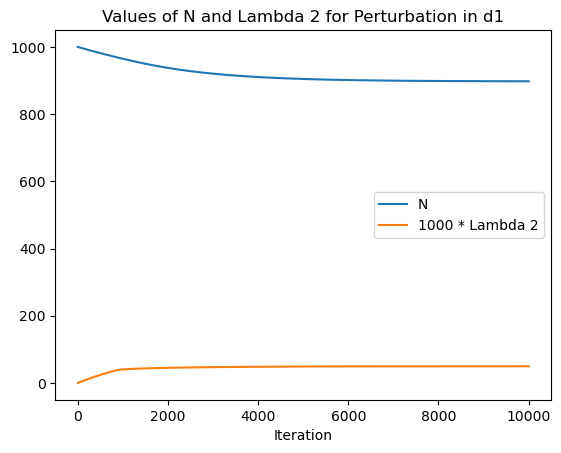

In [11]:
plt.plot(d1a_, label = "N")
plt.plot(1000*lambda_2s, label = "1000 * Lambda 2")
plt.legend()
plt.xlabel("Iteration")
plt.title("Values of N and Lambda 2 for Perturbation in d1")

Text(0.5, 1.0, 'Values of N and 1000*(1 - Lambda 2) for Perturbation in d1')

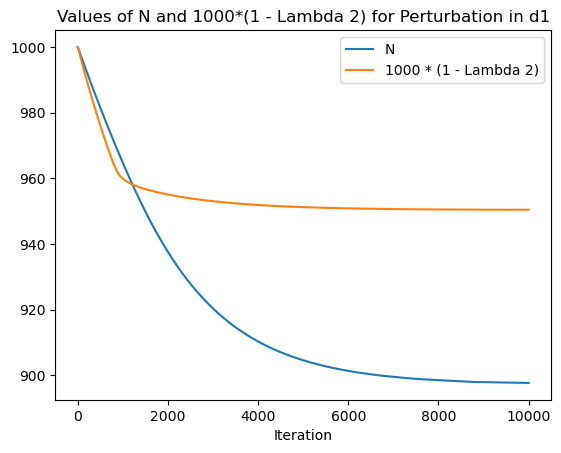

In [12]:
plt.plot(d1a_, label = "N")
plt.plot(1000*(1 - lambda_2s), label = "1000 * (1 - Lambda 2)")
plt.legend()
plt.xlabel("Iteration")
plt.title("Values of N and 1000*(1 - Lambda 2) for Perturbation in d1")